## Installing Pyspark

In [1]:
!pip install pyspark py4j
!pip install findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=bea4561296bcdb04607647fd3107b285ed0da96b566b721c1af600423c933356
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


## Initializing Spark & Downloading The Dataset

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "****"
os.environ['KAGGLE_KEY'] = "****"

In [3]:
!kaggle datasets download -d cynthiarempel/amazon-us-customer-reviews-dataset

100% 20.9G/21.0G [05:20<00:00, 46.6MB/s]
100% 21.0G/21.0G [05:20<00:00, 70.2MB/s]


In [7]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import networkx as nx
import numpy as np
spark = SparkSession.builder.master("local[*]").getOrCreate()
from pyspark.sql.functions import col, array_contains
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, FloatType
from pyspark.sql import functions as f
import itertools
import tempfile
import shutil
import zipfile
import math
import matplotlib.pyplot as plt
import csv
from google.colab import files
from pyspark.sql.functions import desc
from pyspark.sql.functions import col

## Storing Amazon Reviews in a Dataframe

- I am creating the .tsv file from the zipped folder, creating a temporary directory to store the file in.
- Create a dataframe and filter it and storing the filtered contents in a new dataframe

In [ ]:
zip_file = zipfile.ZipFile('/content/amazon-us-customer-reviews-dataset.zip')
review_file = "amazon_reviews_us_Major_Appliances_v1_00.tsv"
temp_dir = tempfile.mkdtemp()
zip_file.extract(review_file, path=temp_dir)
extracted_file_path = f"{temp_dir}/{review_file}"

local_file_path = "/tmp/amazon_reviews_us_Major_Appliances_v1_00.tsv"
shutil.move(extracted_file_path, local_file_path)

df = spark.read.csv(local_file_path, header=True, inferSchema=True, sep='\t')
selected_df = df.select("product_id", "customer_id")

shutil.rmtree(temp_dir)

## Data Exploration Analysis

In [18]:
df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)



In [19]:
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   16199106|R203HPW78Z7N4K|B0067WNSZY|     633038551|FGGF3032MW Galler...|Major Appliances|          5|            0|          0|   N|                Y|If you need a new...|What a great stov...| 2015-08-31|
|         US|   16374060|R2EAIGVLEALSP3|B002QSXK60|     811766671|Best Hand Clothes...|Major Appliances|          5|    

In [20]:
columns_with_null = [column for column in selected_df.columns if selected_df.filter(col(column).isNull()).count() > 0]

if columns_with_null:
    print("Columns with null values:")
    for column in columns_with_null:
        print(column)
else:
    print("No columns contain null values.")

No columns contain null values.


In [21]:
top_5_star_products = df.filter(df["star_rating"] == 5).groupBy("product_title").count().orderBy(desc("count")).limit(10)
print("Top 10 products with 5-star rating:")
top_5_star_products.show(truncate=False)

top_1_star_products = df.filter(df["star_rating"] == 1).groupBy("product_title").count().orderBy(desc("count")).limit(10)
print("Top 10 products with 1-star rating:")
top_1_star_products.show(truncate=False)

Top 10 products with 5-star rating:
+------------------------------------------------------------------+-----+
|product_title                                                     |count|
+------------------------------------------------------------------+-----+
|GE MWF SmartWater Compatible Water Filter Cartridge - Refrigerator|926  |
|SPT Countertop Dishwasher                                         |698  |
|NewAir AI-100R 28-Pound Portable Icemaker, Red                    |639  |
|Avalon Bay Portable Ice Maker                                     |483  |
|Broan 412402 ADA Capable Non-Ducted Under-Cabinet Range Hood      |475  |
|Whirlpool Washer Lid Switch 3949238                               |450  |
|Koolatron Coke Personal Mini Fridge                               |422  |
|Danby 0.7 cu.ft. Countertop Microwave                             |381  |
|Danby DAR195BL 1.8 cu.ft. All Refrigerator -  Black               |379  |
|Haier HLP21N Pulsator 1-Cubic-Foot Portable Washer             

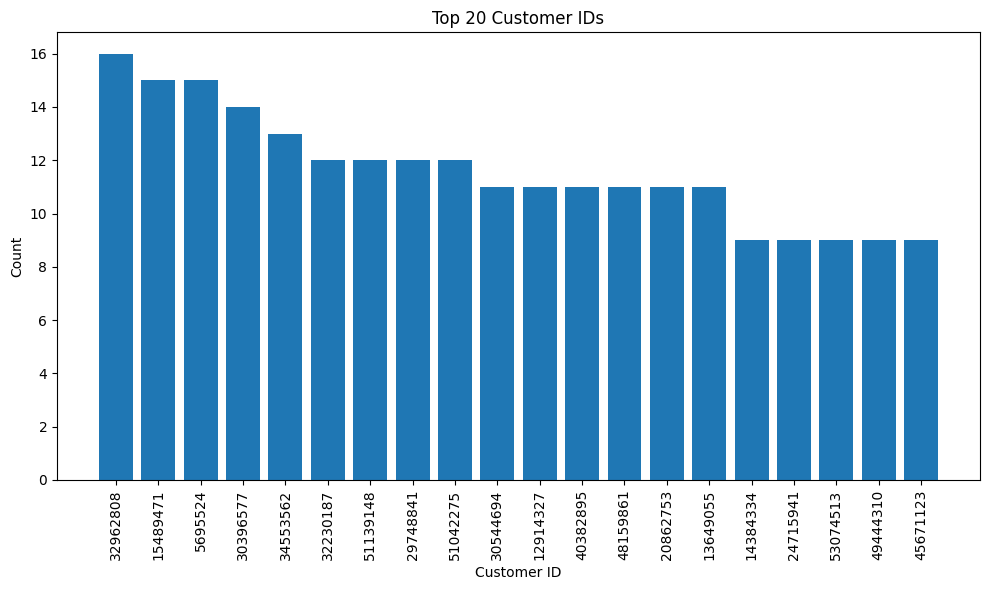

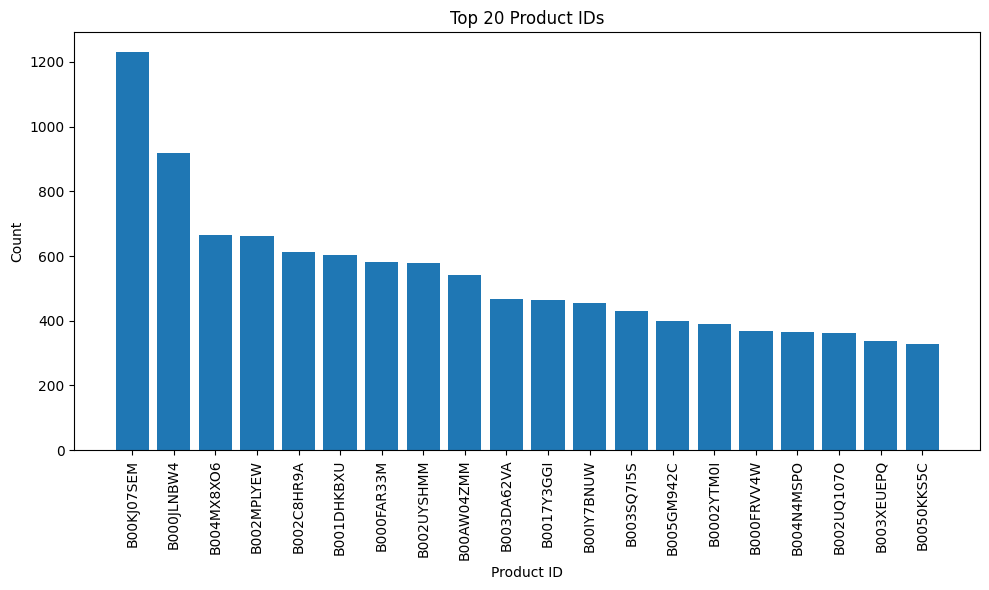

In [22]:
top_customer_ids = selected_df.groupBy("customer_id").count().orderBy(desc("count")).limit(20).toPandas()
top_customer_ids["customer_id"] = top_customer_ids["customer_id"].astype(str)
plt.figure(figsize=(10, 6))
plt.bar(top_customer_ids["customer_id"], top_customer_ids["count"])
plt.xlabel("Customer ID")
plt.ylabel("Count")
plt.title("Top 20 Customer IDs")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

top_product_ids = selected_df.groupBy("product_id").count().orderBy(desc("count")).limit(20).toPandas()

plt.figure(figsize=(10, 6))
plt.bar(top_product_ids["product_id"], top_product_ids["count"])
plt.xlabel("Product ID")
plt.ylabel("Count")
plt.title("Top 20 Product IDs")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Creating Vertices, Edges & Adjacency List

- I decided to use customers as my nodes, so customers will be linked together if they have reviewed a common product
- After creating the nodes, I proceed by creating the edges where each edge contain two customer IDs, one is the source (from) and the other is the destination (to)
- Next thing I do is to divide the edge dataframe into partitions. Using the distinct nodes created, I create an adjacency matrix, in the form of a list, where each node is a key and its values are the other nodes that it is connected to.
- I use the adjacency list later on to compute the pagerank scores directly without creating the transition matrix, as creating it would be costly (memory-wise)

In [23]:
edge_df = selected_df.alias("df1").join(
    selected_df.alias("df2"),
    (col("df1.product_id") == col("df2.product_id")) & (col("df1.customer_id") != col("df2.customer_id")),
    "inner"
).select(
    col("df1.customer_id").alias("src"),
    col("df2.customer_id").alias("dest")
)
edge_df.show()

+--------+--------+
|     src|    dest|
+--------+--------+
|16199106|40178605|
|16199106|48751032|
|16199106|36979298|
|16374060|34900988|
|16374060|33579564|
|16374060|35748628|
|16374060|15816392|
|16374060|47968191|
|16374060|23530267|
|16374060|20442291|
|16374060|49024554|
|16374060|13405765|
|16374060|28768909|
|16374060|44573137|
|16374060|13881919|
|16374060|22659667|
|16374060|23111009|
|16374060|48192347|
|16374060|42152380|
|16374060|23606897|
+--------+--------+
only showing top 20 rows



In [24]:
num_partitions = 100
partitioned_edge_df = edge_df.repartition(num_partitions)
partitioned_edge_df.cache()

DataFrame[src: int, dest: int]

In [25]:
vertices = partitioned_edge_df.select("src", "dest").distinct()
partitioned_edge_df.unpersist()
vertices.cache()
vertices.unpersist()
adjacency_list = vertices.rdd.groupByKey().mapValues(list)
adjacency_list.cache()

PythonRDD[212] at RDD at PythonRDD.scala:53

## Calculating PageRank Scores

- I divided this section into 2 parts:
    - First part is creating a 'calculate_distance' function which calculates the Euclidean distance between the two page rank vectors
    - Second part is creating a function which actually calculates the pagerank scores for each node.
        - I initialize 2 page rank vectors, once has its values = 1/n, where n is number of nodes, the other has its values equal to 1.
        - Next, I join the PR_values pagerank vector with the adjacency list, so now each node has its links and pagerank score.
        - First calculation is the contribution of each node towards its neighbors
        - Second calculation is actually calculating the pagerank score. The damping factor is the taxation variable, which is the probability that we continue random surfing.
        - Final step is calculating the distance and checking if the difference is below a specified threshold.
        - This algorithm is inside a loop where we perform a given number of iterations and the algorithm stops only on two conditions, either the maximum number of iterations is achieved, or the distance is below the threshold.
        - This process is repeated three times but with different damping factors, this is because I am interested in knowing the effect of the damping factor on convergence, whether times increases (iterations) if we increase the damping factor to achieve convergence and also to observe if the distance in each iteration would be different (for example iteration 1 damping factor 0.8 -- iteration 1 damping factor 0.9)

In [26]:
def calculate_distance(PR_values, OLD_PR_values):
    dist = math.sqrt(PR_values.join(OLD_PR_values).mapValues(
        lambda ranks: (ranks[0] - ranks[1])**2
    ).values().sum())
    return dist

In [27]:
def calculate_page_rank(damping_factor, threshold, max_iterations, adjacency_list):
    n = adjacency_list.count()
    distance = 1
    initial_PR = 1.0 / n
    PR_values = adjacency_list.mapValues(lambda neighbors: initial_PR)
    OLD_PR_values = adjacency_list.mapValues(lambda neighbors: 1.0)
    for i in range(max_iterations):
        OLD_PR_values = PR_values
        joinedRDD = PR_values.join(adjacency_list)

        contributionsRDD = joinedRDD.flatMap(
            lambda entry: [(dest, entry[1][0] / len(entry[1][1])) for dest in entry[1][1]]
        )

        PR_values_new = contributionsRDD.reduceByKey(lambda x, y: x + y).mapValues(
            lambda rank: (1 - damping_factor) / n + damping_factor * rank
        )

        PR_values = PR_values_new
        print("Iteration:", i)

        if distance < threshold:
            break

        distance = calculate_distance(PR_values, OLD_PR_values)
        print("Distance:", distance)

    return PR_values.collect()

In [28]:
damping_factors = [0.8, 0.85, 0.9]
threshold = 10e-7
max_iterations = 100
final_PR = []
for damping_factor in damping_factors:
    page_rank_scores = calculate_page_rank(damping_factor, threshold, max_iterations, adjacency_list)
    final_PR.append(page_rank_scores)

Iteration: 0
Distance: 0.0007678845277688204
Iteration: 1
Distance: 0.00021317563021490304
Iteration: 2
Distance: 7.715848352323021e-05
Iteration: 3
Distance: 5.0892303740495564e-05
Iteration: 4
Distance: 3.376428622269167e-05
Iteration: 5
Distance: 2.416003049288616e-05
Iteration: 6
Distance: 1.753876695090322e-05
Iteration: 7
Distance: 1.3067977166705747e-05
Iteration: 8
Distance: 9.827808123882932e-06
Iteration: 9
Distance: 7.48274915747416e-06
Iteration: 10
Distance: 5.73284447764016e-06
Iteration: 11
Distance: 4.422497727704291e-06
Iteration: 12
Distance: 3.426627676407222e-06
Iteration: 13
Distance: 2.666492524095896e-06
Iteration: 14
Distance: 2.0815690771556606e-06
Iteration: 15
Distance: 1.6297279566984212e-06
Iteration: 16
Distance: 1.2789578693668077e-06
Iteration: 17
Distance: 1.0057957208852982e-06
Iteration: 18
Distance: 7.923669686832766e-07
Iteration: 19
Iteration: 0
Distance: 0.0008158773107543731
Iteration: 1
Distance: 0.0002406553012972915
Iteration: 2
Distance: 9.25

## Downloading PageRank Scores For Each Damping Factor

In [29]:
for damping_index, page_rank_scores in enumerate(final_PR):
    damping_factor = damping_factors[damping_index]
    print(f"PageRank scores for damping factor: {damping_factor}")

    for node, rank in page_rank_scores[:10]:
        print(f"Node: {node}, PageRank Score: {rank}")

PageRank scores for damping factor: 0.8
Node: 10947, PageRank Score: 1.3146807086060435e-05
Node: 1171512, PageRank Score: 1.3146807086060435e-05
Node: 2049540, PageRank Score: 1.3146807086060435e-05
Node: 2069433, PageRank Score: 1.3146807086060435e-05
Node: 2115042, PageRank Score: 1.3146807086060435e-05
Node: 2198427, PageRank Score: 1.3146807086060435e-05
Node: 2240646, PageRank Score: 1.3146807086060435e-05
Node: 2610375, PageRank Score: 1.3146807086060435e-05
Node: 3095121, PageRank Score: 1.3146807086060435e-05
Node: 5602983, PageRank Score: 1.3146807086060435e-05
PageRank scores for damping factor: 0.85
Node: 10947, PageRank Score: 1.386678779459007e-05
Node: 1171512, PageRank Score: 1.386678779459007e-05
Node: 2049540, PageRank Score: 1.386678779459007e-05
Node: 2069433, PageRank Score: 1.386678779459007e-05
Node: 2115042, PageRank Score: 1.386678779459007e-05
Node: 2198427, PageRank Score: 1.386678779459007e-05
Node: 2240646, PageRank Score: 1.386678779459007e-05
Node: 261037

In [30]:
file_name_0_8 = "page_rank_scores_0.8.csv"
with open(file_name_0_8, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Node', 'PageRank'])
    writer.writerows(final_PR[0])

files.download(file_name_0_8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
file_name_0_85 = "page_rank_scores_0.85.csv"
with open(file_name_0_85, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Node', 'PageRank'])
    writer.writerows(final_PR[1])

files.download(file_name_0_85)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
file_name_0_9 = "page_rank_scores_0.9.csv"
with open(file_name_0_9, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Node', 'PageRank'])
    writer.writerows(final_PR[2])

files.download(file_name_0_9)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Visualizing Results (Top 20 Influential Customers & Least 20 Influential Customers)

- By visualizing the 3 top 20 plots we can see that increasing the damping factor actually results in a less 'generalized' pagerank scores

In [33]:
def plot_top_least_nodes(final_PR):
    for damping_index, page_rank_scores in enumerate(final_PR):
        damping_factor = damping_factors[damping_index]

        sorted_scores = sorted(page_rank_scores, key=lambda x: x[1], reverse=True)

        top_nodes = sorted_scores[:20]
        least_nodes = sorted_scores[-20:]

        top_node_labels = [node for node, rank in top_nodes]
        top_page_ranks = [rank for node, rank in top_nodes]
        least_node_labels = [node for node, rank in least_nodes]
        least_page_ranks = [rank for node, rank in least_nodes]

        plt.figure(figsize=(10, 6))
        plt.bar(range(len(top_nodes)), top_page_ranks, align='center')
        plt.xticks(range(len(top_nodes)), top_node_labels, rotation='vertical')
        plt.xlabel('Node')
        plt.ylabel('PageRank')
        plt.title(f'Top 20 Nodes (Damping Factor: {damping_factor})')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.bar(range(len(least_nodes)), least_page_ranks, align='center')
        plt.xticks(range(len(least_nodes)), least_node_labels, rotation='vertical')
        plt.xlabel('Node')
        plt.ylabel('PageRank')
        plt.title(f'Least 20 Nodes (Damping Factor: {damping_factor})')
        plt.tight_layout()
        plt.show()

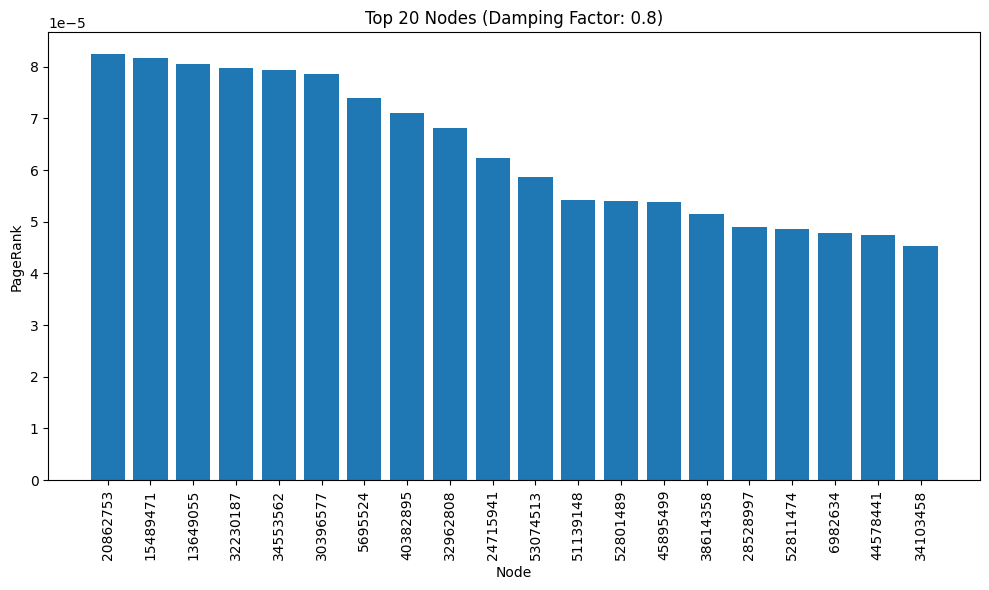

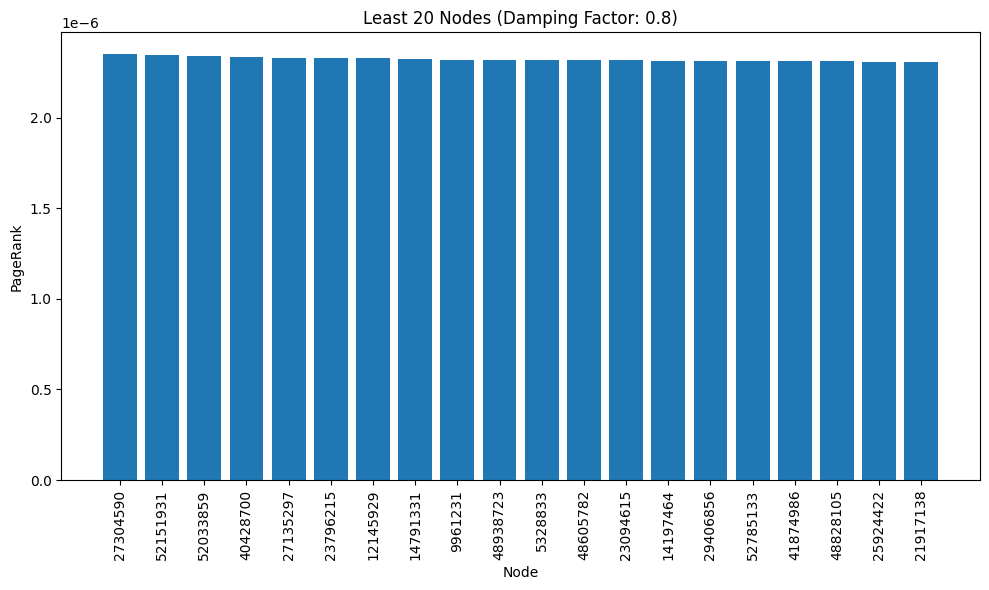

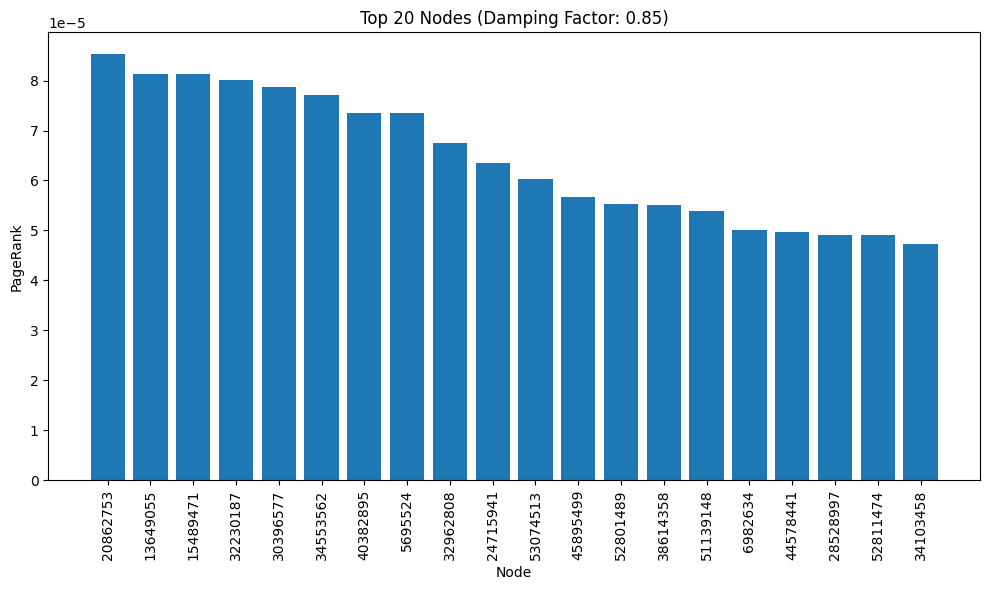

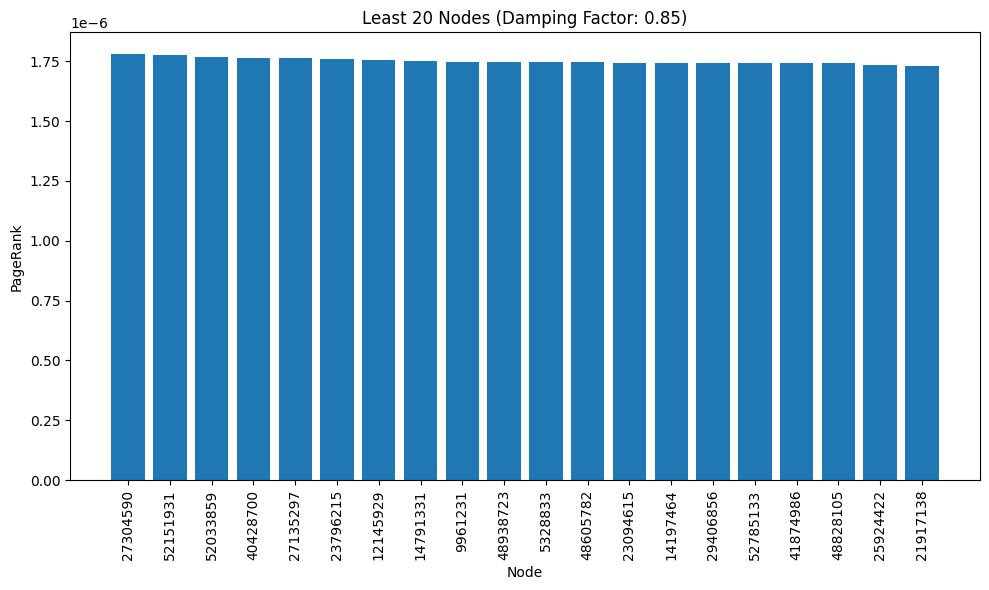

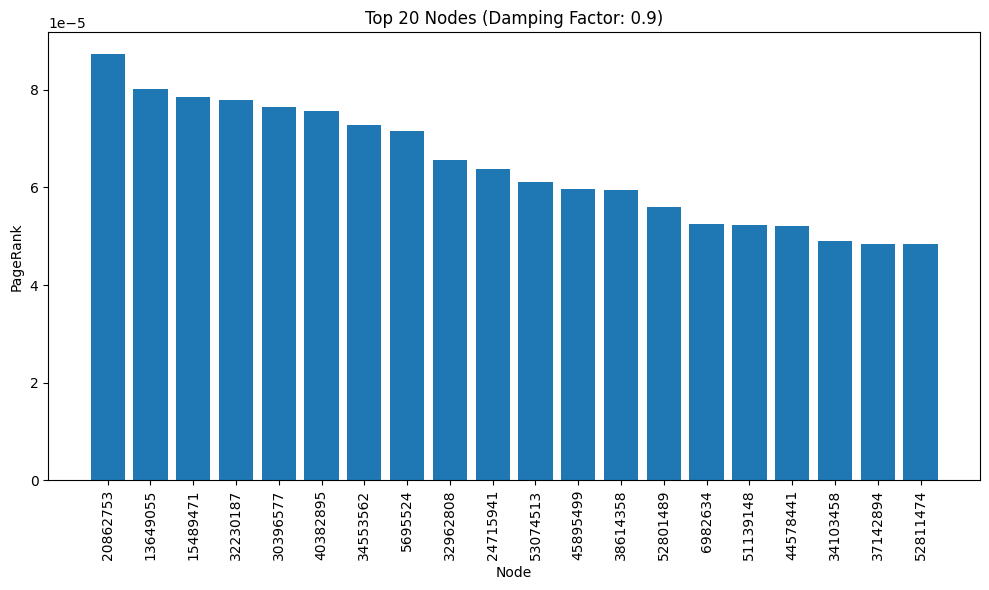

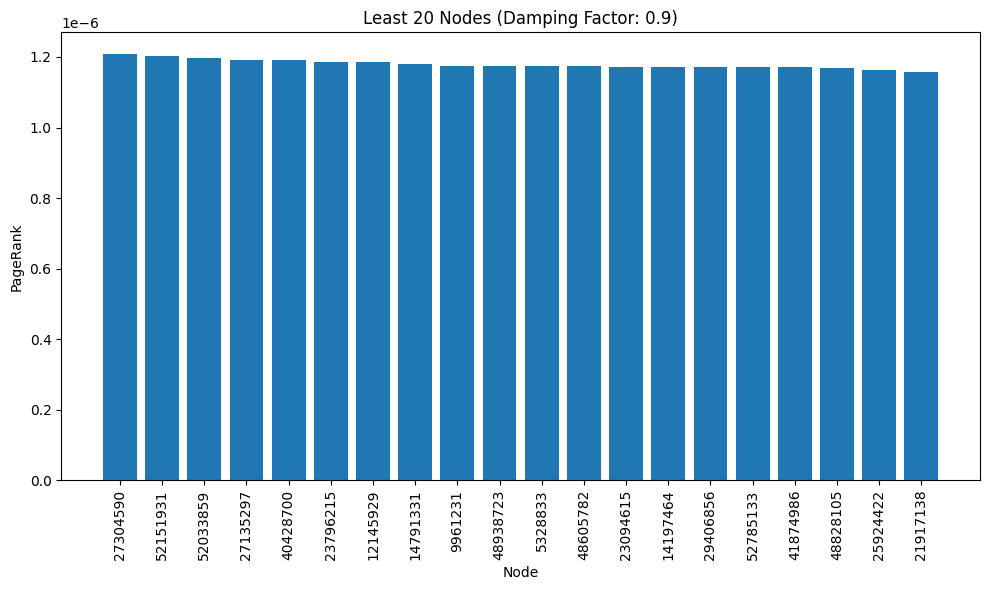

In [34]:
plot_top_least_nodes(final_PR)